In [106]:
import numpy as np
import scipy as sp

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Adding Noise to Regression Predictors is Regularization

In [115]:
def fit_ridge_regression(x, y, lam=0.0):
    X = np.empty(shape=(len(x), 2))
    X[:, 0] = 1
    X[:, 1] = x.reshape(1, -1)
    XtX = np.dot(X.T, X)
    Xty = np.dot(X.T, y)
    reg_matrix = np.array([[0, 0], [0, lam])
    return sp.linalg.solve(XtX + reg_matrix, Xty)

In [116]:
fit_ridge_regression(x, y, 10)

TypeError: data type not understood

## Adding Noise to Regression Predictors

In [65]:
def make_regression_data(b=0, m=1, N=150, sd=0.25):
    x = np.random.uniform(-1.0, 1.0, size=N)
    y = (m*x + b 
         + np.random.normal(0.0, sd, size=N) 
         + (np.random.choice([0, 1], size=N, replace=True, p=[0.85,0.15]) *
            np.random.normal(0.0, 2*sd, size=N)))
    return x, y

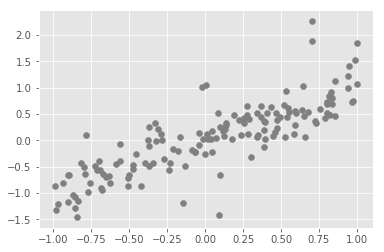

In [66]:
x, y = make_regression_data()

fig, ax = plt.subplots()
ax.scatter(x, y, color="grey")

In [67]:
def add_multiplicitive_random_noise(X, sd=0.25):
    return x * np.random.normal(1.0, sd, size=len(X))

In [68]:
x_rand = add_multiplicitive_random_noise(x, sd=0.5)

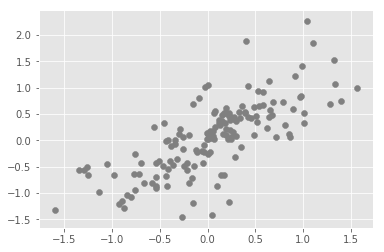

In [70]:
fig, ax = plt.subplots()
ax.scatter(x_rand, y, color="grey")

In [97]:
def is_tail_point(x, p=0.1):
    p_percientle, one_minus_p_percentile = (
        np.percentile(x, 100*p), np.percentile(x, 100*(1 - p)))
    left_mask = x <= p_percientle
    right_mask = x >= one_minus_p_percentile
    print(p_percientle)
    return np.maximum(left_mask, right_mask)

In [101]:
mask = is_tail_point(x)
color = np.array(["grey", "green"])[mask.astype(int)]

-0.781518052049


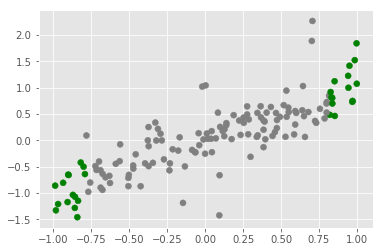

In [104]:
fig, ax = plt.subplots()
ax.scatter(x, y, color=color)

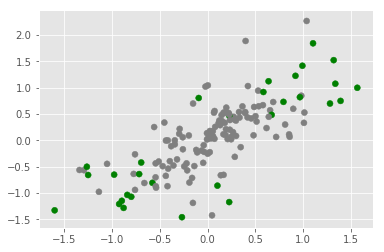

In [105]:
fig, ax = plt.subplots()
ax.scatter(x_rand, y, color=color)

## Tikhonov Regularization

## Proof

### Statement of the Problem

The linear regression problem is to find a vector $\hat \beta$ that minmizes

$$ \hat \beta = argmin_\beta \left| y - X \beta \right|^2 $$

Where $X$ is a matrix of predictiors (the design matrix) and $y$ is a vector of responses.  The idea is that we would like to predict $y$ from $X$ by using a linear function in the columns of $X$.

In our setup, we scale each entry of $X$ by a small amount of gaussian noise before regressing:

$$ x_{ij} \rightarrow \epsilon_{ij} x_{ij} $$

where $\epsilon \sim N(1, \sigma)$.

Of course, we get a different line for each choice of random $\epsilon$; we are interested in what happens *on average*.  That is, we are interested in the solution vector $\beta$ that is the *expectation* under this process

$$ \hat \beta \sim argmin_\beta E_G \left[ \left| y - (G * X) \beta  \right|^2 \right] $$

In this equation, $G$ represents a matrix of random gaussian noise, the $*$ operator is elementwise multiplication of matricies, and $E_G$ marginalizes out the contributions of the noise.

Let's begin by expanding out the quantity inside the expectation:

$$\begin{align*}
\left| y - (G * X) \beta  \right|^2 &= \left( y - (G * X) \beta \right)^t \left( y - (G * X) \beta \right) \\
&= y^t y - 2 y^t (G * X) \beta + \beta^t (G * X)^t (G * X) \beta
\end{align*}$$

### Computing the Quadratic Term

We focus on the last term for the moment, say we name

$$ M = (G * X)^t (G * X) $$

Now a single entry in this matrix is

$$ m_{ij} = \sum_{k} \epsilon_{ki} \epsilon_{kj} x_{ki} x_{kj} $$

which in expectation is

$$ E_G \left[ m_{ij} \right] = \sum_{k} E \left[ \epsilon_{ki} \epsilon_{kj} \right] x_{ki} x_{kj} $$

If $i \neq j$, then $\epsilon_{ki}$ and $\epsilon_{kj}$ are independent random varaibles both drawn from a $N(1, \sigma)$, so

$$ E \left[ \epsilon_{ki} \epsilon_{kj} \right] = 1 \ \text{for} i \neq j $$

For $i = j$, we can compute

$$ E \left[ \epsilon_{ki}^2 \right] = E \left[ (\epsilon_{ki} - 1)^2 + 2 \epsilon_{ki} - 1 \right] = \sigma^2 + 2 - 1 = \sigma^2 + 1 $$

So all together

$$ E \left[ \epsilon_{ki} \epsilon_{kj} \right] = \begin{cases} \sigma^2 + 1 & \text{if} \ i = j \\ 1 & \text{otherwise} \end{cases} $$

This means that

$$ E[M] = \left( \mathbb{1} + diag(\sigma^2) \right) * X^t X  = X^t X + diag(\sigma^2) X^t X $$

Where $\mathbb{1}$ is a matrix with a $1$ in every entry.

### Putting it All Together

Now we can compute the expectation of our entire quantity

$$\begin{align*}
E \left[ \left| y - (G * X) \beta  \right|^2 \right] &= E \left[ y^t y - 2 y^t (G * X) \beta + \beta^t (G * X)^t (G * X) \right] \\
&= y^t y - 2 y^t (E[G] * X) \beta + \beta^t E \left[ M \right] \beta \\
&= y^t y - 2 y^t X \beta + \beta^t X^t X \beta + \beta^2 diag(\sigma^2) X^t X \beta \\
&= \left| y - X \beta \right|^2 + \beta^2 diag(\sigma^2) X^t X \beta \\
&= \left| y - X \beta \right|^2 + \sigma \left| \Gamma \beta \right|^2
\end{align*}$$

Where $\Gamma = \sqrt{ diag \left( X^t X \right) }$.

So, overall, our original problem can be restated as

$$ \hat \beta \sim argmin_\beta \left( \left| y - X \beta \right|^2 + \sigma \left| \Gamma \beta \right|^2 \right) $$

Which we recognise as linear regression with a tikhonov regularization term, with the regularization strength depending on the amount of noise we add to each predictor: more noise results in stronger regularization.

### Ridge Regression

In ridge regression, we always ensure that our predictors are standardized before regressing.  That is, we ensure that $diag(X^t X) = I$.  If we impose this assumption to our resulting regularization problem, we get

$$ \hat \beta \sim argmin_\beta \left( \left| y - X \beta \right|^2 + \sigma \left|\beta \right|^2 \right) $$

That is, under the usual assumptions of unit variance, our add-noise procedure is *in expectation* equivelent to ridge regression with a regularization strenght *equal* to the standard deviation of the noise we add to each predictor.